## Fusione dell'olivina: equilibri solido/liquido per le soluzioni (ideali)

In questo notebook usiamo il programma *melt.py* per studiare il comportamento delle soluzioni solide (in questo caso, si tratta del comportamento alla fusione, ma i principi sono del tutto generali ed applicabili anche al caso transizioni solido/solido).

Volendo trattare soluzioni solide ideali, si è scelto il sistema dell'olivina che presenta solo piccole deviazioni dall'idealità. 

Il programma legge un piccolo database (melt_db.dat; file che deve essere presente nello stesso folder del programma e di questo stesso notebook) che contiene i parametri termodinamici delle fasi pure *forsterite* e *fayalite*, nonché i parametri dei liquidi di composizione corrispondente alle fasi pure. Il programma legge il database con le stesse routine già viste per il programma *gibbs_tp* e relativa esercitazione.

Lanciamo il programma.

In [1]:
%run melt.py
%matplotlib inline

Possiamo esaminare i parametri nel database, per le varie fasi, usando il metodo info() per ciascuna fase. Ad esempio, per la forsterite:

In [2]:
fo.info()

Mineral: forsterite

K0: 125.00 GPa, Kp: 4.00, dK0/dT: -0.0187 GPa/K, V0: 4.3660 J/bar
G0: -2053138.00 J/mol, S0:  95.10 J/mol K

Cp coefficients and powers:
+2.3330e+02  +0.0
+1.4940e-03  +1.0
-6.0380e+05  -2.0
-1.8697e+03  -0.5

Alpha coefficients and powers:
+6.1300e-05  +0.0
-6.1300e-04  -0.5


Se facciamo lo stesso per il liquido di composizione Mg2SiO4 (*foL*), vediamo qualcosa di strano...

In [3]:
foL.info()

Mineral: fo_liquid

K0: 73.00 GPa, Kp: 4.00, dK0/dT: -0.0109 GPa/K, V0: 4.2430 J/bar
G0: -2061346.00 J/mol, S0: -55.00 J/mol K

Cp coefficients and powers:
+2.6790e+02  +0.0

Alpha coefficients and powers:
+1.4500e-04  +0.0
-1.4500e-03  -0.5


In particolare vediamo un valore di entropia *negativo* (cosa assurda dal punto di vista termodinamico) e, anche, il valore di *G0* (l'energia libera alle condizioni standard) è *minore* (in valore relativo: va considerato il segno e non solo il valore assoluto) del *G0* della forsterite. Questo vorrebbe dire che a T=298.15 K sarebbe stabile il liquido e non il solido! 

Questo perchè, come accade in molti casi, i parametri termodinamici della fase *foL* non sono <i>termodinamicamente consistenti</i>, anche se sono *internamente consistenti* (nello specifico database) con quelli della forsterite e descrivono correttamente la relazione tra le due fasi <b>a patto di utilizzarli nell'intervallo di temperatura e pressione per cui sono stati calibrati</b> (e questo intevallo non contiene evidentemente le condizioni standard P/T). Si parla in questi casi di *assessment*: i parametri *termodinamici* vengono ottimizzati per riprodurre gli equilibri di fase osservati sperimentalmente, senza porre attenzione al loro significato termodinamico intrinseco. Questa è una faccenda a cui porre sempre particolare attenzione: è in generale *pericoloso* spingersi col modeling termodinamico al di là dei limiti P/T, e anche  X, per i quali i parametri del database sono stati calibrati.

Diamo un'occhiata al comportamento dell'energia libera delle due fasi al variare della temperatura (tra 300 e 2500 K):

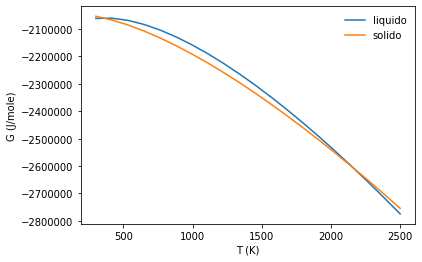

In [4]:
t_list=np.linspace(300,2500,20)
g_foL_list=np.array([])
g_fo_list=np.array([])

for it in t_list:
    igL=foL.g_tp(it,0.)
    ig=fo.g_tp(it,0.)
    g_foL_list=np.append(g_foL_list,igL)
    g_fo_list=np.append(g_fo_list,ig)

plt.figure()
plt.plot(t_list,g_foL_list,label="liquido")
plt.plot(t_list,g_fo_list,label="solido")
plt.legend(frameon=False)
plt.xlabel("T (K)")
plt.ylabel("G (J/mole)")
plt.show()

In effetti vediamo che l'anomalia per cui  $G_{0}^{liq} < G_{0}^{sol}$  si ha solo per temperature vicino all'ambiente. per T più alte, l'energia libera del liquido è maggiore di quella del solido fino a circa 2200 K, dove si ha il *crossover* e il sistema fonde.

Usiamo la funzione *fusion* per determinare la temperatura di fusione della forsterite. La funzione richiede i nomi delle due fasi solida e liquida e la pressione (in questo caso, P=0 GPa); il parametro opzionale *prt* produce la stampa del risultato.

In [5]:
fusion("fo","foL",0,prt=True)

Temperatura di fusione: 2161.01 K


Facciamo lo stesso per la fayalite.

In [6]:
fusion("fa","faL",0,prt=True)

Temperatura di fusione: 1480.31 K


La funzione *fusion* lavora insieme alla funzione *deltaG*:

```

def deltaG(phase,phaseL,it,ip):
        gs=eval(phase+'.g_tp(it,ip)')
        gl=eval(phaseL+'.g_tp(it,ip)')
        dg=gl-gs
        return dg**2
    
def fusion(phase,phaseL,ip,prt=False):
    t_ini=1800.
    tf=lambda it: deltaG(phase,phaseL,it,ip)
    t_fusion=scipy.optimize.minimize(tf,t_ini,tol=0.001)
    if prt:
        print("Temperatura di fusione: %5.2f K" % t_fusion.x[0])
    else:
        return t_fusion
        
```

la funzione *deltaG* calcola il quadrato della differenza tra i valori di energia libera del solido e del liquido a una data temperatura (e pressione): restituisce dunque un valore sempre positivo che è pari a zero quando le due energie libere sono uguali (il che si verifica alla temperatura di fusione). La funzione *fusion* cerca la temperatura alla quale *deltaG* è minima (cioè zero) che è appunto la temperatura di fusione. La ricerca del minimo viene fatta usando la funzione *minimize* della libreria *scipy.optimize*, partendo da un guess iniziale di 1800K (*t_ini*).

La funzione principale del programma del programma *melt.py* si chiama proprio *melt*. Questa determina il diagramma di stato *TX* che descrive l'equilibrio solido/liquido nel sistema dell'olivina. Il risultato di *melt* alla pressione ambiente è mostrato nella cella seguente:

Temperatura di fusione della forsterite: 2161.01 K
Temperatura di fusione della fayalite: 1480.31 K


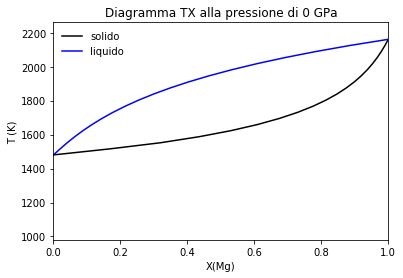


  T (K)   X(Mg)sol  X(Fe)sol  X(Mg)liq  X(Fe)liq
 1480.31    0.00      1.00      0.00      1.00  
 1516.14    0.17      0.83      0.02      0.98  
 1551.97    0.32      0.68      0.04      0.96  
 1587.79    0.44      0.56      0.06      0.94  
 1623.62    0.53      0.47      0.09      0.91  
 1659.45    0.61      0.39      0.12      0.88  
 1695.27    0.68      0.32      0.15      0.85  
 1731.10    0.73      0.27      0.18      0.82  
 1766.92    0.78      0.22      0.21      0.79  
 1802.75    0.81      0.19      0.25      0.75  
 1838.58    0.85      0.15      0.30      0.70  
 1874.40    0.87      0.13      0.35      0.65  
 1910.23    0.90      0.10      0.40      0.60  
 1946.05    0.92      0.08      0.46      0.54  
 1981.88    0.94      0.06      0.53      0.47  
 2017.71    0.95      0.05      0.61      0.39  
 2053.53    0.97      0.03      0.69      0.31  
 2089.36    0.98      0.02      0.78      0.22  
 2125.19    0.99      0.01      0.89      0.11  
 2161.01    1.00   

In [7]:
melt(nt=20)

La funzione *melt*, chiamando la funzione *composition*) ricerca inizialmente le temperature di fusione dei termini puri *fo* e *fa*. Imposta poi il calcolo tra queste due temperature, tra le quali le due fasi solida e liquida coesistono certamente. Quindi, per ogni valore di temperatura, ricerca preliminarmente il punto di intersezione ($x_{int}$) tra le curve $\mu$ del solido e del liquido

$$\mu_s=x_{fo}\mu_{fo}^{0}+x_{fa}\mu_{fa}^{0}+RT\left[x_{fo}log(x_{fo})+x_{fa}log(x_{fa})\right]$$

$$\mu_L=x_{foL}\mu_{foL}^{0}+x_{faL}\mu_{faL}^{0}+RT\left[x_{foL}log(x_{foL})+x_{faL}log(x_{faL})\right]$$

con $x_{fa}=1-x_{fo}$ e $x_{faL}=1-x_{foL}$. A partire dalla composizione trovata, viene minimizzata l'energia libera della miscela eterogenea delle due fasi solida e liquida, ciascuna con la propria composizione ($x_s$ e $x_L$).

$$G(q_s,q_L,x_s,x_L)=q_s\mu_s(x_s)+q_L\mu_L(x_L)$$

dove $q_s$ e $q_L$ sono le quantità (in moli) delle fasi solida e liquida. In questa ricerca del minimo si impone che

- il numero di moli totali $q_s+q_L$ sia fisso (e pari ad 1);
- il numero di moli totali del componente *fo* sia fisso al valore $x_{int}$: $\ \ q_sx_{fo}+q_Lx_{foL}=x_{int}$

A una pressione diversa (per esempio 5 GPa), chiamiamo la funzione *melt* passandogli il valore di pressione (il default è 0.):

Temperatura di fusione della forsterite: 2497.40 K
Temperatura di fusione della fayalite: 1836.95 K


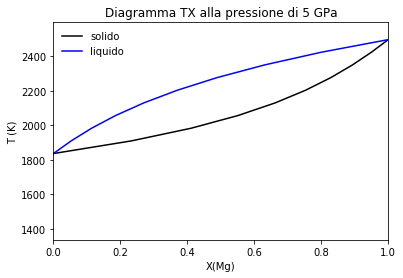


  T (K)   X(Mg)sol  X(Fe)sol  X(Mg)liq  X(Fe)liq
 1836.95    0.00      1.00      0.00      1.00  
 1910.33    0.23      0.77      0.05      0.95  
 1983.72    0.41      0.59      0.11      0.89  
 2057.10    0.55      0.45      0.19      0.81  
 2130.48    0.66      0.34      0.27      0.73  
 2203.87    0.75      0.25      0.37      0.63  
 2277.25    0.83      0.17      0.49      0.51  
 2350.64    0.89      0.11      0.63      0.37  
 2424.02    0.95      0.05      0.80      0.20  
 2497.40    1.00      0.00      1.00      0.00  


In [8]:
melt(5)

La funzione *composition* può essere utilizzata da sola, per calcolare ad una certa temperatura, pressione e composizione *globale* di un componente (*fo*), le composizioni delle fasi solida e liquida all'equilibrio e la loro abbondanza relativa (in moli). A T=2500 K e P=5 GPa, per una $x_{fo}$=0.50 (*globale*: portiamo in fusione una fase 50\%*fo* - 50\%*fa*), abbiamo 

In [9]:
composition(2100,5,xval=0.5)

Pressione 5.0 GPa,  Temperatura 2100.0 K

Per una composizione X(Mg) globale pari a 0.50: 
X(Mg) fase solida 0.62, quantità fase solida 0.69
X(Mg) fase liquida 0.23, quantità fase liquida 0.31


Vogliamo ora sfruttare la funzione *g_phase* per visualizzare le curve di energia libera delle fasi liquida e solida, data una certa temperatura e pressione. Nel caso la temperatura ricada nell'intervallo di coesistenza del solido e del liquido, viene tracciato anche il segmento che rappresenta l'energia libera della miscela eterogenea solido + liquido.

Il primo argomento di *g_phase* è la temperatura; il secondo è la pressione:

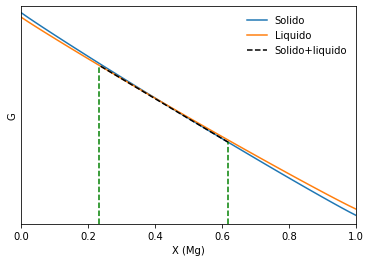

Composizione delle fasi: frazione molare X(Mg):
Fase liquida:  0.23
Fase solida:   0.62


In [10]:
g_phase(2100,5)

A una temperatura più bassa di quella di fusione del componente *basso-fondente* (fayalite):

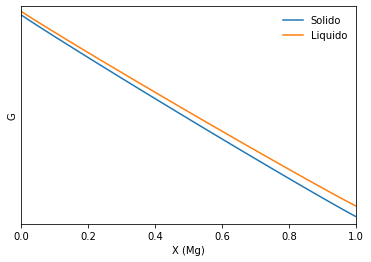

In [11]:
g_phase(1600,5)

Vediamo che la curva del solido è sempre sotto quella del liquido per qualunque composizione.

A una temperatura maggiore di quella di fusione del componente *alto-fondente* (forsterite):

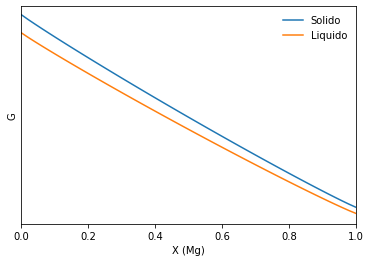

In [12]:
g_phase(2800,5)

l'energia libera del liquido è più bassa di quella del solido per ogni composizione.